# 多層パーセプトロン

## MLPの構築と学習

MLPは以下の画像のように線形層をつなげていったものです。
最後の出力層は回帰問題の場合は線型回帰、分類問題のときにはロジスティクス回帰と全く同じ構造をしています。
<img src="https://cdn-ak.f.st-hatena.com/images/fotolife/k/konchangakita/20210101/20210101143833.png" width="600" />

単純に線形層をつなげるだけだと全体としては線形の関数にしかならないので、各層の出力には活性化関数という非線形関数を作用させ、全体としても非線形の関数を表現できるようにします。

### パーセプトロンの復習
少し復習 (ゼロからのディープラーニング P41)

<img src="../../image/lec_3/parceptron.png" width="600" />

上の図では$x_1$と$x_2$の２つの入力信号を受けとり、$y$を出力するパーセプトロンです。

このパーセプトロンを式で表すと以下になります。

<img src="../../image/lec_3/siki.png" width="600">

これは入力信号の総和が$h(x)$という関数によって変換され、その変換された値が出力$y$になるということを表しています。

またこの$h(x)$のような関数を一般に活性化関数といいます。

活性化関数は入力信号の総和がどのように活性化するかを決定する役割があります。

イメージ的には以下のようになります。

<img src="../../image/lec_3/kasseika.png" width="600">


> なぜ線形層だけではだめなのか


活性化関数に線形関数を用いるとどんなに層を深くしても、それと同じことを行う隠れ層のないネットワークが必ず存在することに起因する。

かんたんな例を元に考えると、

$ h(x) = cx $ を活性化関数として $y(x)=h(h(h(x)))$ を行う計算を3層のネットワークに対応させて考える。 

この計算は$ y(x) = c^3x$ となり $y(x) = ax (a = c^3)$ と一回の掛け算で（隠れ層を用いない）ネットワークで表現できてしまう。 

そのため層を重ねることの恩恵を受けるには活性化関数には非線形関数を使用する必要がある


詳しくは以下参照

https://tarepan.hatenablog.com/entry/2015/10/06/183036




In [5]:
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
from torch.utils.data import TensorDataset, DataLoader 
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16), 
    nn.ReLU(),
    nn.Linear(16, 10)
)

`nn.Sequential`は次々にnn.Moduleの層を積み重ねてネットワークを構築する際に使用します。

このように層がい直線に積み重なった形のニューラルネットワークを`Feedforward型`といいます。

今回用いた`nn.ReLU`近年のニューラルネットワークの学習で利用される代表的なReLUという活性化関数です。



ReLU 関数


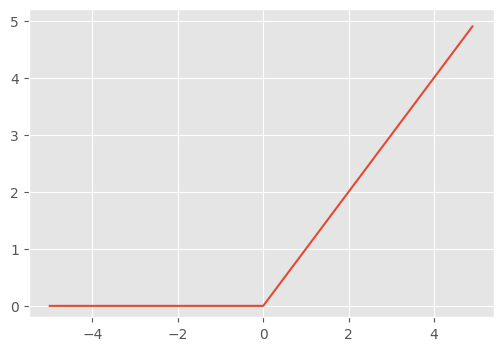

In [8]:
print("ReLU 関数")
x = np.arange(-5.0,5,0.1)
y = x * (x > 0)
plt.figure(figsize=(6,4))
plt.plot(x,y)
plt.ylim(-0.2,5.2)
plt.show()

特にFeedforward型ニューラルネットワークの微分を求める際には`backpropagation`(誤差逆伝播法)と呼ばれる動的計画法を用いたアルゴリズムを使用します。

In [12]:
# 手書き数字データセットの読み込み
digits = load_digits()
X = digits.data
y = digits.target

# ndarray を torch.Tensor に変換
X = torch.tensor(X, dtype=torch.float32).to("cuda:0")
y = torch.tensor(y, dtype=torch.int64).to("cuda:0")

net.to("cuda:0")

# 損失関数には交差エントロピー誤差を用いる
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters())

# 損失関数のログ
losses = []

for epoc in range(100):
    # 勾配を初期化
    optimizer.zero_grad()
    # 順伝播
    y_pred = net(X)
    # 損失を計算
    loss = loss_fn(y_pred, y)
    # 誤差逆伝播
    loss.backward()
    # パラメータ更新
    optimizer.step()
    # 損失を記録
    losses.append(loss.item())

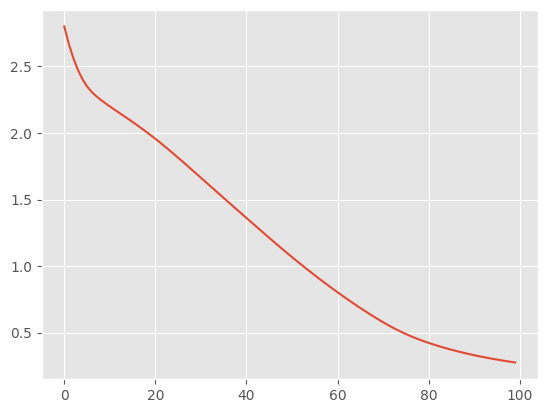

In [17]:
plt.plot(losses)
plt.show()

## DatasetとDataLoader

これまで学習にはすべてのデータをまとめて利用してきましたが、データが増えたり、ネットワークの層が深くなり、パラメータが増えていくとすべてのデータがメモリに乗らなくなってきます。

そのため、ここでデータの一部を使用した本来のSGDの学習法のやり方を紹介します。

PytorchにはDatasetとDataLoaderという概念があり、ミニバッチ学習やデータのシャッフル、更には並列処理をかんたんに行えるようになっています。

TensorDatasetはDatasetを継承したクラスで、特徴量XとラベルYをまとめるコンテナであり、このTensorDatasetをDataLoaderに渡すことでforループ時にデータの一部のみをかんたんに受け取れるようになります。

またTensorDatasetにはTensorのみ渡すことができます。

In [13]:
# TensorDataset を作成
ds = TensorDataset(X, y)

# 異なる順番で６４個のデータを取り出すDasaloaderを作成
loader = DataLoader(ds, batch_size=64, shuffle=True)

net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())



In [ ]:
losses = []
for epoc in range(10):
    running_loss = 0.0
    # xx, yyは64個分のみ受け取れる
    for xx, yy in loader:
        optimizer.zero_grad()
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss)

今回用いたDatasetはsklearnからでしたが、もちろん独自に作成することもでき、大量の画像ファイルをすべてメモリ上で管理せず、都度読み込む形式で学習することもでき、様々な用途があります。

## 学習効率化のTips

ニューラルネットワークは非常に表現力の高いモデルですが、一方で過学習してしまい、他のデータに適用できなかったり、あるいは学習が不安定で長い時間がかかったりする問題があります。

ここではそれらを克服する2つの代表的な手法である、`Dropout`と`Nomalization`を学習します。

### Dropoutによる正則化

ニューラルネットワークに限らず、機械学習の問題として過学習が挙げられます。

特に深いニューラルネットワークはパラメータが多く、十分なデータがないと過学習しがちです。

先程の手書き文字認識で使用したネットワークをより深くすると以下のようになります。


In [29]:
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = torch.tensor(X_train, dtype=torch.float32).to("cuda:0")
X_test = torch.tensor(X_test, dtype=torch.float32).to("cuda:0")
y_train = torch.tensor(y_train, dtype=torch.int64).to("cuda:0")
y_test = torch.tensor(y_test, dtype=torch.int64).to("cuda:0")


In [30]:
k = 100
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, 10)
).to("cuda:0")


In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
ds = TensorDataset(X_train, y_train)
loader = DataLoader(ds, batch_size=32, shuffle=True)

In [44]:
train_losses = []
test_losses = []
for epoc in range(100):
    running_loss = 0.0
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / i)
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, y_test)
test_losses.append(test_loss.item())


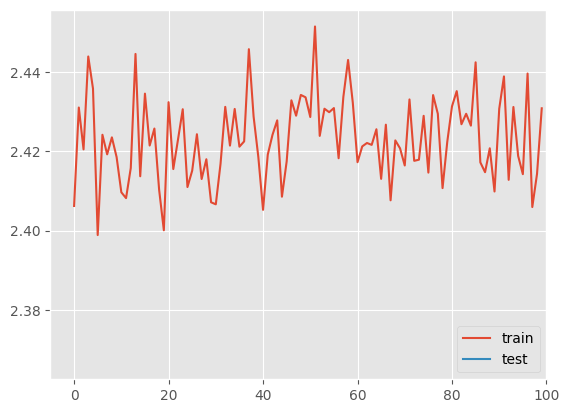

In [45]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlim(-5, 100)
plt.legend()
plt.show()

過学習を抑えることを正則化といいます。

正則化には様々な方法がありますが、Dropoutというランダムにいくつかのノードを意図的にしようしないという方法がよく用いられます。

また、Dropoutはネットワークの訓練時のみに行い、予測時には使用しません。

Pytorchではモデルのtrainとevalメソッドでこの挙動を切り替えることができます。

In [43]:
# 確率0.5でランダムにノードを落とす
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, 10)
).to("cuda:0")



In [ ]:
optimizer = optim.Adam(net.parameters())

train_losses = []
test_losses = []

for epoc in range(100):
    running_loss = 0.0
    net.train()
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / i)
    net.eval()
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, y_test)
test_losses.append(test_loss.item())